In [1]:
using PyPlot
using Distributions
using Statistics
using DelimitedFiles
using StatsBase
using LinearAlgebra

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
        "font.size" => 18,
        "axes.labelsize" => 30,
        "xtick.labelsize" => 20,
        "ytick.labelsize" => 20,
        "legend.fontsize" => 20,
)
merge!(rcParams, font0);

In [2]:
function wasted_papers(wasted_hours, papers_phd_hour, N_PHD)
    
    return @. papers_phd_hour * N_PHD * wasted_hours
    
end

function wasted_money(hour_price, wasted_hours, N_PHD)
    
    return @. hour_price * wasted_hours * N_PHD
        
end

function simulate_queue(realisations, max_N, max_t, max_M)
   
    θ = 2.39 #Parameter for the interarrival time distribution
    μ = 3 #Mean of heating time distribution
    σ = sqrt(1.17) #Variance of heating time distribution

    interarrival_time_distribution = Truncated(Exponential(θ), 0, 6) #(1/θ)*exp(-t/θ)
    heating_time_distribution = 1 .+ rand(Truncated(Gamma(3.6, 0.6), 0, 8), 10^6) #Normal(μ, σ)

    queue_times = []

    for iterator in 1 : realisations
        
        start_times = [rand(interarrival_time_distribution)]
        
        #Start with the M occupied microwaves
        for i in 2 : max_M
        
            t_i = start_times[i-1] + rand(interarrival_time_distribution)
            
            append!(start_times, t_i)
            
        end

        t = start_times[end] #time
        N = 0 #number of PhD students that have used the microwave

        while (t < max_t) & (N < max_N)

            t += rand(interarrival_time_distribution)

            #Add the time of arrival of this PhD
            append!(start_times, t)

            #Add 1 to the number of PhD that had already come
            N += 1

            finish_times = []
            
            #Check if the M PhD using the microwave have already finished.
            for i in 1 : max_M
               
                append!(finish_times, start_times[end-i] + rand(heating_time_distribution))
                
            end

            tmin = minimum(finish_times)

            if t < tmin

                append!(queue_times, tmin-t)

                start_times[end] += (tmin-t)

            end
            #else
                #append!(queue_times, 0.0)
                
            #end

        end

    end
    
    return queue_times

end

simulate_queue (generic function with 1 method)

In [3]:
realisations = 10^5

max_N = 40 #Number of PhD students
max_t = 30 #Time to heat the meal
max_M = 2 #Number of microwaves

N_PHD = 40
hour_price = 1200 / (37.5*4)
papers_phd_hour = 2.5 / (37.5*52)

queue_times_current_situation = @time simulate_queue(realisations, max_N, max_t, max_M);

p_w_current_situation = wasted_papers(queue_times_current_situation./60.0, papers_phd_hour, N_PHD) .* 210;

m_w_current_situation = wasted_money(hour_price, queue_times_current_situation./60.0, N_PHD) .* 210

microwaves = collect(2 : 1: 6)

papers_loss_M = zeros(length(microwaves))
money_loss_M = zeros(length(microwaves))

j = 0

queue_times_dist_M = []

@time for M in microwaves

    j += 1

    realisations = 10^5

    max_N = 40 #Number of PhD students
    max_t = 30 #Time to heat the meal
    max_M = M #Number of microwaves

    N_PHD = 40
    hour_price = 1200 / (37.5*4)
    papers_phd_hour = 2.5 / (37.5*52)

    queue_times_j = simulate_queue(realisations, max_N, max_t, max_M)

    p_w = wasted_papers(queue_times_j./60.0, papers_phd_hour, N_PHD) .* 210
    m_w = wasted_money(hour_price, queue_times_j./60.0, N_PHD) .* 210;

    papers_loss_M[j] =  mean(p_w)
    money_loss_M[j] =  mean(m_w)
    
    append!(queue_times_dist_M, [queue_times_j])

end

  2.622737 seconds (16.48 M allocations: 501.624 MiB, 10.24% gc time, 14.50% compilation time)
 12.442832 seconds (83.96 M allocations: 2.328 GiB, 11.21% gc time, 0.95% compilation time)


In [4]:
data_papers_CRA, header = readdlm("papers_vs_microwaves_CRA.txt", header=true)
data_money_CRA, header = readdlm("money_vs_microwaves_CRA.txt", header=true)
data_papers_OAO, header = readdlm("papers_vs_microwaves_OAO.txt", header=true)
data_money_OAO, header = readdlm("money_vs_microwaves_OAO.txt", header=true);

experimental_time = readdlm("tiempo_cola.txt");

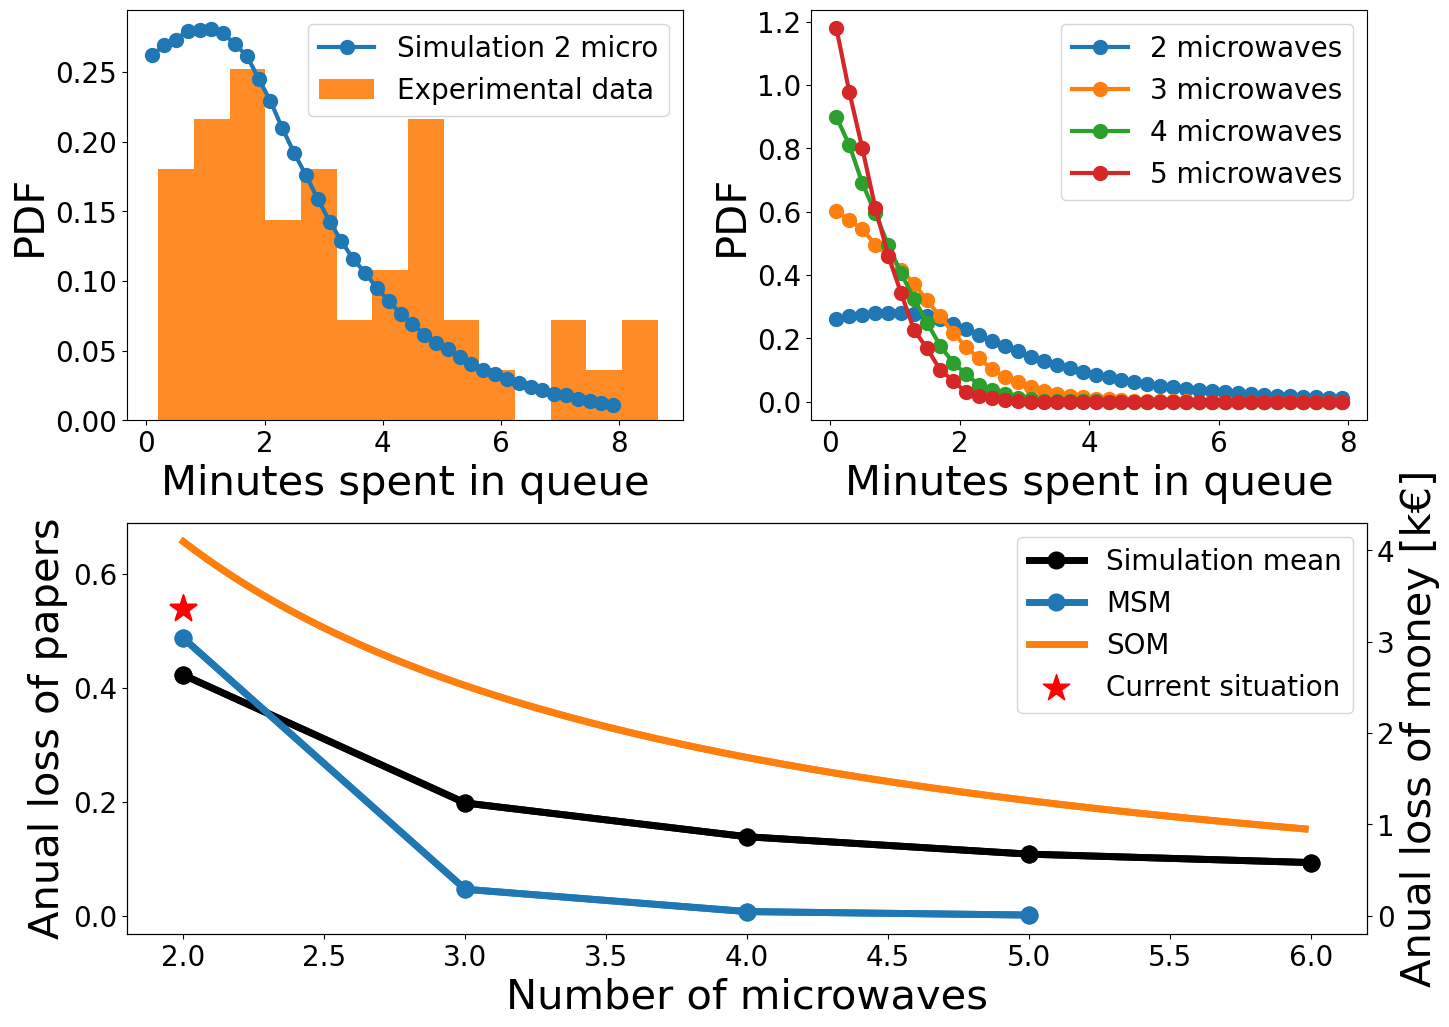

In [5]:
fig, ax = plt.subplot_mosaic("""AABB
    DDDD""", figsize=(8*2, 6*2))

hist =  LinearAlgebra.normalize(fit(Histogram, Float64.(queue_times_dist_M[1]), 0:0.2:8), mode=:pdf)
    
weights = hist.weights

edges = collect(hist.edges[1])

xs = edges .+ (edges[2]-edges[1])/2;

ax["A"].plot(xs[1:end-1], weights, marker="o", lw=3, ms=10, label="Simulation $(microwaves[1]) micro")

ax["A"].hist(experimental_time[:, 1], density=true, bins=14, label="Experimental data", alpha=0.9)

ax["A"].set_xlabel("Minutes spent in queue", fontsize=30)
ax["A"].set_ylabel("PDF", fontsize=30)

for i in 1 : 4

    hist =  LinearAlgebra.normalize(fit(Histogram, Float64.(queue_times_dist_M[i]), 0:0.2:8), mode=:pdf)
    
    weights = hist.weights
    
    edges = collect(hist.edges[1])

    xs = edges .+ (edges[2]-edges[1])/2;

    ax["B"].plot(xs[1:end-1], weights, marker="o", lw=3, ms=10, label="$(microwaves[i]) microwaves")
    
end

ax["A"].legend()

ax["B"].set_xlabel("Minutes spent in queue", fontsize=30)
ax["B"].set_ylabel("PDF", fontsize=30)
ax["B"].legend()

ax["D"].plot(microwaves, papers_loss_M, marker="o", lw=5, markersize=12, color="k", label="Simulation mean")
ax["D"].plot(data_papers_CRA[:, 1][1:end-1], data_papers_CRA[:, 2][1:end-1], marker="o", lw=5, markersize=12, label="MSM")
ax["D"].plot(data_papers_OAO[:, 1], data_papers_OAO[:, 2], lw=5, label="SOM")

ax["D"].scatter([2], [0.54], marker="*", s=400, label="Current situation", color="r")

ax["D"].set_ylabel("Anual loss of papers")
ax["D"].set_xlabel("Number of microwaves")

ax["D"].legend()

ax2 = ax["D"].twinx()

ax2.plot(microwaves, money_loss_M/1000, marker="o", lw=5, markersize=12, color="k", label="Simulation mean")
ax2.plot(data_money_CRA[:, 1][1:end-1], data_money_CRA[:, 2][1:end-1]/1000, marker="o", lw=5, markersize=12, label="MSM")
ax2.plot(data_money_OAO[:, 1], data_money_OAO[:, 2]/1000, lw=5, label="SOM")

ax2.scatter([2], [3.36], marker="*", s=400, label="Current situation", color="r")

ax2.set_ylabel("Anual loss of money [k€]")

plt.subplots_adjust(wspace=0.6, hspace=0.25)

#plt.savefig("simulation.png", dpi=300, bbox_inches="tight")